## Variant 3 (Fear Greed + Markov Switching)

In [69]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

### Data Collection

In [71]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

start_date = '2014-01-01'
end_date = '2024-01-01'

# market data
market_data = yf.download("VOO", start=start_date, end=end_date)
market_data['Returns'] = np.log(market_data['Close'] / market_data['Close'].shift(1))  # Log returns
market_returns = market_data['Returns']
market_data = market_data.dropna()
market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]

# ticker data
data = yf.download(tickers, start=start_date, end=end_date)
closing_prices = data["Adj Close"]
returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_capitalisation(tickers):
    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_caps

data.tail(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  7 of 7 completed


Price                       Adj Close                                     \
Ticker                            AMD        AMZN       INTC        META   
Date                                                                       
2023-12-15 00:00:00+00:00  139.149994  149.970001  45.549957  333.645508   
2023-12-18 00:00:00+00:00  138.899994  154.070007  45.086163  343.308563   
2023-12-19 00:00:00+00:00  140.149994  153.789993  46.043350  349.026733   
2023-12-20 00:00:00+00:00  135.470001  152.119995  45.155243  347.950836   
2023-12-21 00:00:00+00:00  139.910004  153.839996  46.457802  352.742523   
2023-12-22 00:00:00+00:00  139.600006  153.419998  47.365639  352.045258   
2023-12-26 00:00:00+00:00  143.410004  153.410004  49.832600  353.479736   
2023-12-27 00:00:00+00:00  146.070007  153.339996  50.089161  356.468323   
2023-12-28 00:00:00+00:00  148.759995  153.380005  49.724056  356.956451   
2023-12-29 00:00:00+00:00  147.410004  151.940002  49.585903  352.613037   

Price                                                             Close  \
Ticker                          NVDA       RIVN        TSLA         AMD   
Date                                                                      
2023-12-15 00:00:00+00:00  48.876141  22.830000  253.500000  139.149994   
2023-12-18 00:00:00+00:00  50.062805  23.799999  252.080002  138.899994   
2023-12-19 00:00:00+00:00  49.589939  24.350000  257.220001  140.149994   
2023-12-20 00:00:00+00:00  48.097359  23.180000  247.139999  135.470001   
2023-12-21 00:00:00+00:00  48.976116  23.580000  254.500000  139.910004   
2023-12-22 00:00:00+00:00  48.816162  23.209999  252.539993  139.600006   
2023-12-26 00:00:00+00:00  49.265030  23.590000  256.609985  143.410004   
2023-12-27 00:00:00+00:00  49.402992  23.730000  261.440002  146.070007   
2023-12-28 00:00:00+00:00  49.507965  23.540001  253.179993  148.759995   
2023-12-29 00:00:00+00:00  49.507965  23.459999  248.479996  147.410004   

Price                                             ...       Open             \
Ticker                           AMZN       INTC  ...       NVDA       RIVN   
Date                                              ...                         
2023-12-15 00:00:00+00:00  149.970001  46.160000  ...  48.194000  22.750000   
2023-12-18 00:00:00+00:00  154.070007  45.689999  ...  49.400002  22.600000   
2023-12-19 00:00:00+00:00  153.789993  46.660000  ...  49.424000  23.959999   
2023-12-20 00:00:00+00:00  152.119995  45.759998  ...  49.654999  24.049999   
2023-12-21 00:00:00+00:00  153.839996  47.080002  ...  48.811001  23.540001   
2023-12-22 00:00:00+00:00  153.419998  48.000000  ...  49.195000  23.730000   
2023-12-26 00:00:00+00:00  153.410004  50.500000  ...  48.967999  23.469999   
2023-12-27 00:00:00+00:00  153.339996  50.759998  ...  49.511002  23.799999   
2023-12-28 00:00:00+00:00  153.380005  50.389999  ...  49.643002  23.680000   
2023-12-29 00:00:00+00:00  151.940002  50.250000  ...  49.813000  23.600000   

Price                                    Volume                       \
Ticker                           TSLA       AMD       AMZN      INTC   
Date                                                                   
2023-12-15 00:00:00+00:00  251.210007  70178600  110039100  84553800   
2023-12-18 00:00:00+00:00  253.779999  45199500   62512800  27895700   
2023-12-19 00:00:00+00:00  253.479996  63739800   43171300  35358800   
2023-12-20 00:00:00+00:00  256.410004  54671700   50322100  38159100   
2023-12-21 00:00:00+00:00  251.899994  47179400   36305700  28320500   
2023-12-22 00:00:00+00:00  256.760010  35370400   29480100  30053700   
2023-12-26 00:00:00+00:00  254.490005  47157400   25067200  60287400   
2023-12-27 00:00:00+00:00  258.350006  49033400   31434700  52148000   
2023-12-28 00:00:00+00:00  263.660004  63800700   27057000  27705200   
2023-12-29 00:00:00+00:00  255.100006  62028200   39789000  29266500   

Price                                                                 

In [5]:
closing_prices.tail(10)

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Date,,,,,,,
2023-12-15 00:00:00+00:00,139.149994,149.970001,45.549957,333.645508,48.876141,22.830000,253.500000
2023-12-18 00:00:00+00:00,138.899994,154.070007,45.086163,343.308563,50.062805,23.799999,252.080002
2023-12-19 00:00:00+00:00,140.149994,153.789993,46.043350,349.026733,49.589939,24.350000,257.220001
2023-12-20 00:00:00+00:00,135.470001,152.119995,45.155243,347.950836,48.097359,23.180000,247.139999
2023-12-21 00:00:00+00:00,139.910004,153.839996,46.457802,352.742523,48.976116,23.580000,254.500000
2023-12-22 00:00:00+00:00,139.600006,153.419998,47.365639,352.045258,48.816162,23.209999,252.539993
2023-12-26 00:00:00+00:00,143.410004,153.410004,49.832600,353.479736,49.265030,23.590000,256.609985
2023-12-27 00:00:00+00:00,146.070007,153.339996,50.089161,356.468323,49.402992,23.730000,261.440002
2023-12-28 00:00:00+00:00,148.759995,153.380005,49.724056,356.956451,49.507965,23.540001,253.179993


The covariance matrix of asset returns is calculated, from which the covariance and correlation plots are displayed. Both plots are derived from the same data, however the latter provides better visualisation of asset covariances.

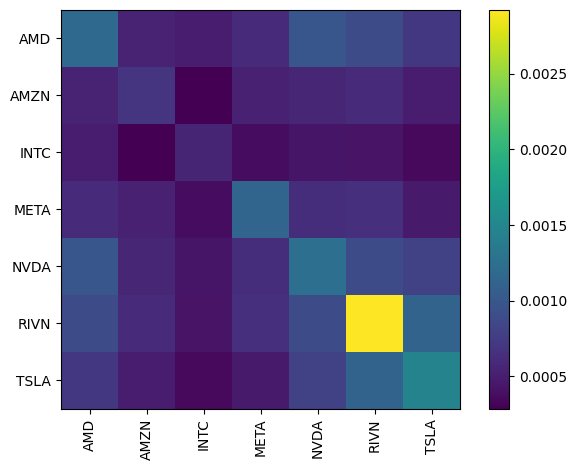

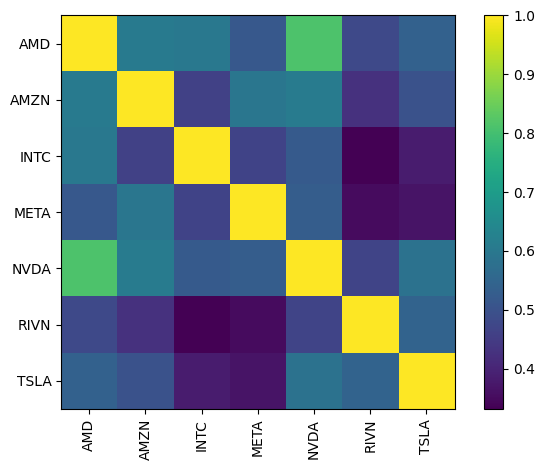

In [110]:
covariance_matrix = returns.cov()

covariance_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=False)
correlation_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=True)

The dataframe for the above covariance matrices can be seen below for further clarity of how returns correlate between assets.

In [111]:
covariance_matrix

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Ticker,,,,,,,
AMD,0.001181,0.000547,0.000489,0.000602,0.000990,0.000892,0.000709
AMZN,0.000547,0.000687,0.000286,0.000529,0.000567,0.000604,0.000501
INTC,0.000489,0.000286,0.000563,0.000376,0.000436,0.000425,0.000348
META,0.000602,0.000529,0.000376,0.001150,0.000633,0.000644,0.000476
NVDA,0.000990,0.000567,0.000436,0.000633,0.001252,0.000897,0.000791
RIVN,0.000892,0.000604,0.000425,0.000644,0.000897,0.002920,0.001124
TSLA,0.000709,0.000501,0.000348,0.000476,0.000791,0.001124,0.001462


### Get Prior and Delta

Using the previously defined function, market prices from the Vanguard S&P 500 index and market capitalisations for each ticker can be retrieved. These are used to calculate the 'Prior' and 'Delta'.

<li>Delta represents the risk-aversion co-efficient, and is used to scale the equilibrium returns. This determines the risk aversion of the investor.
<li>Prior is used to calculate the equilibrium returns based on the market portfolio (VOO). This is the benchmark portfolio which will be skewed once investor views are provided in the following section.

In [37]:
market_caps = get_market_capitalisation(tickers)

delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

prior

Ticker
AMD     0.022673
AMZN    0.022029
INTC    0.021314
META    0.022341
NVDA    0.023087
RIVN    0.022816
TSLA    0.022615
dtype: float64

### Market Logarithmic Returns

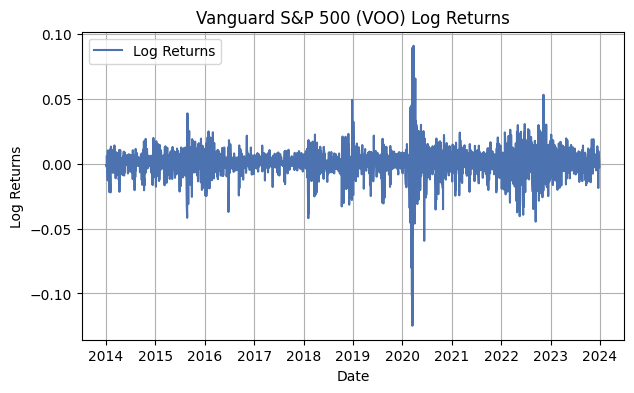

In [9]:
def plot_log_returns(market_data):
    plt.figure(figsize=(7,4))
    plt.plot(market_data.index, market_data['Returns'], label='Log Returns')
    plt.title('Vanguard S&P 500 (VOO) Log Returns')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

plot_log_returns(market_data)

### Calculate All Sentiment Indicators

In [20]:
def calculate_stock_rsi(tickers, period=14):
    """
    Calculates the Relative Strength Index (RSI) values for a list of stocks. 
    Used as a momentum indicator to analyse recent overbought or oversold conditions 
    and the general trend (upward/downward) for a given stock.

    Parameters:
    tickers: list of str
        List of stock tickers.
    period: int
        Lookback period for RSI

    Returns:
    rsi_dict: dict
        Dictionary of tickers with their corresponding RSI value. Higher values indicate
        a stronger upward trend, versus lower values indicating a downtrend.
    """
    if not isinstance(tickers, list):
        print("Tickers must be a list of strings")
        return None

    rsi_dict = {}
    for ticker in tickers:
        try:
            stock_data = yf.Ticker(ticker).history(period="1y")

            stock_data['Change'] = stock_data['Close'].diff()

            stock_data['Gain'] = np.where(stock_data['Change'] > 0, stock_data['Change'], 0)
            stock_data['Loss'] = np.where(stock_data['Change'] < 0, -stock_data['Change'], 0)

            stock_data['Avg_Gain'] = stock_data['Gain'].rolling(window=period, min_periods=1).mean()
            stock_data['Avg_Loss'] = stock_data['Loss'].rolling(window=period, min_periods=1).mean()

            stock_data['RS'] = stock_data['Avg_Gain'] / stock_data['Avg_Loss']
            stock_data['RSI'] = 100 - (100 / (1 + stock_data['RS']))

            rsi_dict[ticker] = stock_data['RSI'].iloc[-1]
        
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating RSI")
            rsi_dict[ticker] = None

    return rsi_dict

def calculate_stock_price_strength(tickers, period=52):
    """
    Calculates the Relative Price Strength, indicating whether the stock
    is currently outperforming the market (used as a benchmark) based on the
    price in proximity with its 52-week high.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    price_strength_dict: dict
        Tuple of tickers with their corresponding price strength value, including
        price strength, high, low, and current price or 'None' if the value is 0.
    """
    price_strength_dict = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker).history(period="1y")

            high = stock_data['High'].max()
            low = stock_data['Low'].min()
            current_price = stock_data['Close'].iloc[-1]

            # Proximity to 52-week high
            price_strength = (current_price - low) / (high - low) if high - low != 0 else None

            price_strength_dict[ticker] = (price_strength, high, low, current_price)

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating price strength")
            price_strength_dict[ticker] = None

    return price_strength_dict

def calculate_stock_price_breadth(tickers):
    """
    Calculates the Stock Price Breadth which indicates the advancing
    versus declining stock price.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    breadth_ratios: dict
        Dictionary of tickers with their corresponding breadth ratio.
    """
    breadth_ratios = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker)
            prior_year_history = stock_data.history(period="1y")

            close_data = prior_year_history['Close'].tolist()
            volume_data = prior_year_history['Volume'].tolist()

            rising_vol = 0
            declining_vol = 0

            for i in range(1, len(close_data)):
                price_change = close_data[i] - close_data[i - 1]
                if price_change > 0:
                    rising_vol += volume_data[i]
                elif price_change < 0:
                    declining_vol += volume_data[i]

            # edge case for declining_vol == 0
            if declining_vol == 0:
                breadth_ratio = float('inf') if rising_vol > 0 else 0
            else:
                breadth_ratio = rising_vol / declining_vol

            breadth_ratios[ticker] = breadth_ratio

        except Exception as error:
            print(f"An error occurred for {ticker}: {error}")
            breadth_ratios[ticker] = None

    return breadth_ratios

def calculate_market_volatility(tickers):
    """
    Calculates annual market volatility for a given list tickers 
    based on a rolling 50 day standard deviation of daily returns.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    volatility_dict: dict
        Dictionary of tickers with their corresponding annual
        volatility value. For any errors, this is set to 'None'.
    """
    volatility_dict = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker).history(period="1y")
            stock_data['Returns'] = stock_data['Close'].pct_change()
            stock_data['Volatility'] = stock_data['Returns'].rolling(window=50).std() * np.sqrt(252)
            latest_volatility = stock_data['Volatility'].iloc[-1]
            volatility_dict[ticker] = latest_volatility

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating volatility")
            volatility_dict[ticker] = None

    return volatility_dict

def calculate_put_call_ratio(tickers):
    """
    Calculates the put-call ratio for a given list of tickers
    based on the volume of options.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    put_call_dict: dict
        Dictionary of tickers with their corresponding put-call ratio, 
        calculated as the total put volume divided by total call volume.
        For any errors, this is set to 'None'.
    """
    put_call_dict = {}
    
    for ticker in tickers:
        try:
            # get options chain for ticker
            options = yf.Ticker(ticker).option_chain()
            puts = options.puts
            calls = options.calls

            # total volume
            total_put_volume = puts['volume'].sum()
            total_call_volume = calls['volume'].sum()

            # calculate ratio
            put_call_ratio = total_put_volume / total_call_volume if total_call_volume != 0 else None
            put_call_dict[ticker] = put_call_ratio

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating put-call ratio")
            put_call_dict[ticker] = None
    
    return put_call_dict

### Get Stock-Specific Fear-Greed Score

In [88]:
def get_fear_greed(tickers):
    """
    Calculates an overarching fear-greed score based on the individual
    stock sentiment indicators. First retrieves individual values, then
    normalises each value to the same scale. Sets the weight of each indicator,
    then times this by the respective normalised value.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    fear_greed_scores_dict: dict
        Dictionary of tickers with their corresponding amalgamated fear-greed score.
        For any errors, this is set to 'None'.
    """
    fear_greed_scores_dict = {}

    # call individual sentiment function
    rsi_dict = calculate_stock_rsi(tickers)
    price_strength_dict = calculate_stock_price_strength(tickers)
    breadth_dict = calculate_stock_price_breadth(tickers)
    volatility_dict = calculate_market_volatility(tickers)
    put_call_ratio_dict = calculate_put_call_ratio(tickers)

    for ticker in tickers:
        try:
            # get all dict values
            rsi = rsi_dict.get(ticker, None)
            price_strength_tuple = price_strength_dict.get(ticker, None)  # Get the whole tuple
            breadth_ratio = breadth_dict.get(ticker, None)
            volatility = volatility_dict.get(ticker, None)
            put_call_ratio = put_call_ratio_dict.get(ticker, None)

            # get price_strength from tuple (price_strength, high, low, current_price)
            price_strength = price_strength_tuple[0] if price_strength_tuple else None

            # normalize each indicator with validation
            normalised_rsi = float(rsi) / 100 if rsi is not None and isinstance(rsi, (int, float)) else 0.5
            normalised_price_strength = float(price_strength) if price_strength is not None and isinstance(price_strength, (int, float)) else 0.5
            normalised_breadth = min(max(float(breadth_ratio) / 2, 0), 1) if breadth_ratio is not None and isinstance(breadth_ratio, (int, float)) else 0.5
            normalised_volatility = min(max(float(volatility) / 100, 0), 1) if volatility is not None and isinstance(volatility, (int, float)) else 0.5
            normalised_put_call_ratio = min(max(float(put_call_ratio), 0), 1) if put_call_ratio is not None and isinstance(put_call_ratio, (int, float)) else 0.5

            print(f"Ticker: {ticker}, RSI: {normalised_rsi}, Strength: {normalised_price_strength}, Breadth: {normalised_breadth}, Volatility: {normalised_volatility}, Put-Call: {normalised_put_call_ratio}")

            # equal weights for each indicator
            rsi_weight = 0.2
            price_strength_weight = 0.2
            breadth_weight = 0.2
            volatility_weight = 0.2
            put_call_ratio_weight = 0.2

            fear_greed_score = (
                normalised_rsi * rsi_weight +
                normalised_price_strength * price_strength_weight +
                normalised_breadth * breadth_weight +
                normalised_volatility * volatility_weight +
                normalised_put_call_ratio * put_call_ratio_weight
            )

            fear_greed_scores_dict[ticker] = fear_greed_score

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when attempting to calculate the fear-greed score")
            fear_greed_scores_dict[ticker] = None

    return fear_greed_scores_dict

fear_greed_scores_dict = get_fear_greed(tickers)

print(f"\nFear-Greed Scores:\n {fear_greed_scores_dict}")

Ticker: TSLA, RSI: 0.40954464293516407, Strength: 0.6875964772415475, Breadth: 0.5730759859569043, Volatility: 0.008461916936006961, Put-Call: 1
Ticker: NVDA, RSI: 0.4846719924258088, Strength: 0.8619960776661418, Breadth: 0.635474018456378, Volatility: 0.0035536617027075914, Put-Call: 0.5318510484083446
Ticker: AMZN, RSI: 0.37355161491549815, Strength: 0.8563237861971683, Breadth: 0.5889887207318162, Volatility: 0.0031395977880316, Put-Call: 0.4095527519415539
Ticker: META, RSI: 0.3557850528343887, Strength: 0.8694459977322108, Breadth: 0.5439595938323534, Volatility: 0.0028199891696393496, Put-Call: 0.5030715844222764
Ticker: RIVN, RSI: 0.45626070020961207, Strength: 0.40241934876040025, Breadth: 0.5008850849602449, Volatility: 0.008045334311884169, Put-Call: 0.957722147187235
Ticker: INTC, RSI: 0.508680419881453, Strength: 0.0549392975399905, Breadth: 0.48668853236369486, Volatility: 0.004745047332605375, Put-Call: 0.37894802095279423
Ticker: AMD, RSI: 0.3133336784008573, Strength: 

In [94]:
total = sum(fear_greed_scores_dict.values())

normalized_values = {ticker: (value / total) for ticker, value in fear_greed_scores_dict.items()} # normalise to equate to 1
print(normalized_values)

fg_scores_df = pd.DataFrame.from_dict(normalized_values, orient='index', columns=['Normalised Fear-Greed Score'])
fg_scores_array = np.array(list(normalized_values.values()))

fg_scores_df

{'TSLA': 0.18189486653318201, 'NVDA': 0.17095323291419431, 'AMZN': 0.15153314863871747, 'META': 0.15448875092143086, 'RIVN': 0.1579009885417645, 'INTC': 0.09737541381868954, 'AMD': 0.0858535986320213}


,Normalised Fear-Greed Score
TSLA,0.181895
NVDA,0.170953
AMZN,0.151533
META,0.154489
RIVN,0.157901
INTC,0.097375
AMD,0.085854


### Fit Markov-Switching Model

In [80]:
def fit_markov_switching(market_data):
    model = MarkovRegression(market_data['Returns'], k_regimes=2, switching_variance=True)
    results = model.fit()
    return results

results = fit_markov_switching(market_data)
results.summary()

c:\Users\Chantal.Maskell\Documents\Projects\Black_Litterman_Portfolio_Optimisation\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                Returns   No. Observations:                 2515
Model:               MarkovRegression   Log Likelihood                8309.822
Date:                Thu, 02 Jan 2025   AIC                         -16607.643
Time:                        16:54:33   BIC                         -16572.663
Sample:                             0   HQIC                        -16594.948
                               - 2515                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      7.206      0.000       0.001       0.001
sigma2      3.184e-05   1.82e-06     17.523      0.000    2.83e-05    3.54e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -1.597      0.110      -0.002       0.000
sigma2         0.0003   1.73e-05     17.259      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9773      0.005    198.022      0.000       0.968       0.987
p[1->0]        0.0435      0.009      4.715      0.000       0.025       0.062
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### Get Regime Probabilities

In [11]:
# smoothed probs for each regime
smoothed_probs_regime_0 = results.smoothed_marginal_probabilities[0]
smoothed_probs_regime_1 = results.smoothed_marginal_probabilities[1]

# transition probabilities matrix
transition_probs = results.params[-4:]  # last 4 parameters are usually transition probabilities

# regimes for each observation
predicted_regimes = results.predicted_marginal_probabilities.idxmax(axis=1)

# other fitted parameters
means = results.params[:2]  # mean for regime 0 and mean for regime 1
variances = results.params[2:4]  # variances for regime 0 and regime 1

print("Smoothed probabilities for Regime 0:\n", smoothed_probs_regime_0)
print("Smoothed probabilities for Regime 1:\n", smoothed_probs_regime_1)
print("Transition probabilities:\n", transition_probs)
print("Predicted regimes:\n", predicted_regimes)
print("Means of each regime:", means)
print("Variances of each regime:", variances)

Smoothed probabilities for Regime 0:
 Date
2014-01-03    0.985658
2014-01-06    0.992799
2014-01-07    0.995220
2014-01-08    0.995805
2014-01-09    0.993361
                ...   
2023-12-22    0.940632
2023-12-26    0.972330
2023-12-27    0.982840
2023-12-28    0.983633
2023-12-29    0.976061
Name: 0, Length: 2515, dtype: float64
Smoothed probabilities for Regime 1:
 Date
2014-01-03    0.014342
2014-01-06    0.007201
2014-01-07    0.004780
2014-01-08    0.004195
2014-01-09    0.006639
                ...   
2023-12-22    0.059368
2023-12-26    0.027670
2023-12-27    0.017160
2023-12-28    0.016367
2023-12-29    0.023939
Name: 1, Length: 2515, dtype: float64
Transition probabilities:
 const[0]     0.001090
const[1]    -0.000955
sigma2[0]    0.000032
sigma2[1]    0.000298
dtype: float64
Predicted regimes:
 Date
2014-01-03    0
2014-01-06    0
2014-01-07    0
2014-01-08    0
2014-01-09    0
             ..
2023-12-22    1
2023-12-26    0
2023-12-27    0
2023-12-28    0
2023-12-29    0
L

### Define View Confidences

In [95]:
def set_view_confidences_for_views(results, views, threshold_bull=0.7, threshold_bear=0.3):
    smoothed_probs = results.smoothed_marginal_probabilities
    
    view_confidences = []
    
    # check views matches a valid range
    if len(views) > len(smoothed_probs[0]):
        raise ValueError("Number of views exceeds the number of time steps in smoothed probabilities.")
    
    # iterate over views and assign confidences
    for idx in range(len(views)):
        bull_prob = smoothed_probs[0][idx]
        bear_prob = smoothed_probs[1][idx]
        
        if bull_prob > threshold_bull:
            confidence = bull_prob
        elif bear_prob > threshold_bear:
            confidence = bear_prob
        else:
            confidence = max(bull_prob, bear_prob)
        
        view_confidences.append(confidence)
    
    return view_confidences

generated_confidences = set_view_confidences_for_views(results, fg_scores_array, threshold_bull=0.7, threshold_bear=0.3)
generated_confidences

C:\Users\Chantal.Maskell\AppData\Local\Temp\ipykernel_15944\973134172.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bull_prob = smoothed_probs[0][idx]
C:\Users\Chantal.Maskell\AppData\Local\Temp\ipykernel_15944\973134172.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bear_prob = smoothed_probs[1][idx]


[0.9856577708877108,
 0.9927987974322122,
 0.9952199459918101,
 0.9958046276131647,
 0.9933607600393655,
 0.9843247178994083,
 0.9557671531767158]

### Filter Regime Returns

In [32]:
def filter_returns_by_regime(results, market_data):
    smoothed_probs = results.smoothed_marginal_probabilities

    if not isinstance(smoothed_probs, pd.DataFrame):
        smoothed_probs = pd.DataFrame(smoothed_probs)

    # assign most likely regime to each time step
    market_data['Regime'] = smoothed_probs.idxmax(axis=1)

    # filter returns by regime
    regime_returns = {
        regime: market_data[market_data['Regime'] == regime]['Returns']
        for regime in range(smoothed_probs.shape[1])
    }

    # cov matrix for each regime
    covariance_matrices = {
        regime: market_data[market_data['Regime'] == regime].cov()
        for regime in range(smoothed_probs.shape[1])
    }

    return regime_returns, covariance_matrices

regime_returns, covariance_matrices = filter_returns_by_regime(results, market_data)

for regime, cov_matrix in covariance_matrices.items():
    print(f"Regime {regime} covariance matrix:\n{cov_matrix}\n")

Regime 0 covariance matrix:
                   Open          High           Low         Close  \
Open       6.569677e+03  6.600072e+03  6.540462e+03  6.574969e+03   
High       6.600072e+03  6.631404e+03  6.571073e+03  6.606322e+03   
Low        6.540462e+03  6.571073e+03  6.512287e+03  6.546673e+03   
Close      6.574969e+03  6.606322e+03  6.546673e+03  6.582092e+03   
Adj Close  7.017763e+03  7.051554e+03  6.987250e+03  7.025355e+03   
Volume     7.148381e+07  7.193072e+07  7.091291e+07  7.145755e+07   
Returns    1.274563e-02  1.541520e-02  1.563195e-02  1.816561e-02   
Regime     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              Adj Close        Volume     Returns  Regime  
Open       7.017763e+03  7.148381e+07    0.012746     0.0  
High       7.051554e+03  7.193072e+07    0.015415     0.0  
Low        6.987250e+03  7.091291e+07    0.015632     0.0  
Close      7.025355e+03  7.145755e+07    0.018166     0.0  
Adj Close  7.508561e+03  7.657415e+07    0.018974 

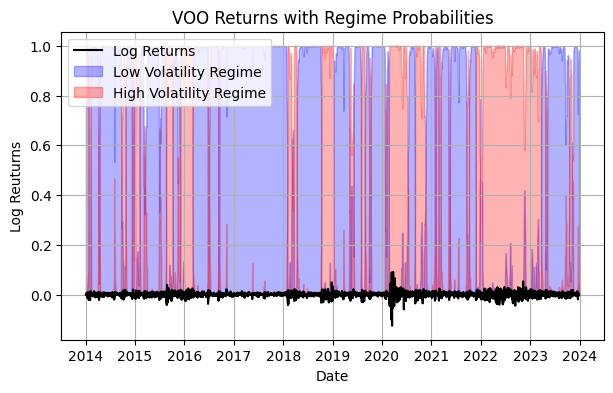

In [33]:
# To visalise when the market is in bull/bear periods. 
# can see the likelihood of each one occuring using smoothed probabilities
def plot_regime_probabilities(market_data):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(market_data. index, market_data['Returns'], label='Log Returns', color='black')
    
    ax.fill_between(market_data.index, 0, results.smoothed_marginal_probabilities[0], color='blue', alpha=0.3, label='Low Volatility Regime')
    ax.fill_between(market_data.index, 0, results.smoothed_marginal_probabilities[1], color='red', alpha=0.3, label='High Volatility Regime') # Any red sections show the market in high volatility period

    ax.set_title('VOO Returns with Regime Probabilities')
    ax.set_xlabel('Date')
    ax.set_ylabel("Log Reuturns")
    plt.grid()
    ax.legend(loc='upper left')
    plt.show()

plot_regime_probabilities(market_data)

### Run Black Litterman Model

The Black Litterman Model is then called with all previous values, including the covariance matrix, prior, fear-greed generated views, picking matrix, omega, Markov-generated view confidences, tau, and delta.

To show that absolute views have not been used for the model, this has been explicitly set to 'None'. For the omega, Idzorek's method is employed (this is what requires the picking matrix to be defined). In the case that the number of views matches the number of tickers, a picking matrix wouldn't be necessary, as this would have an implicit mapping.

In [ ]:
bl = BlackLittermanModel(
    covariance_matrix,
    pi=prior,
    absolute_views=None,
    Q=fg_scores_df,
    P=None,
    omega="idzorek",
    view_confidences=generated_confidences,
    tau=0.025,
    risk_aversion=delta
)

### Calculate Posterior Returns

In [97]:
posterior_returns = bl.bl_returns()
posterior_returns

Ticker
AMD     0.181082
AMZN    0.170019
INTC    0.151097
META    0.154505
NVDA    0.158070
RIVN    0.098541
TSLA    0.089152
dtype: float64

In [101]:
views_series = pd.Series(normalized_values)

# shoiuld also add generated confidences
returns_df = pd.DataFrame([prior, posterior_returns, views_series], index=["Prior", "Posterior", "Views"]).T
returns_df

,Prior,Posterior,Views
AMD,0.022673,0.181082,0.085854
AMZN,0.022029,0.170019,0.151533
INTC,0.021314,0.151097,0.097375
META,0.022341,0.154505,0.154489
NVDA,0.023087,0.158070,0.170953
RIVN,0.022816,0.098541,0.157901
TSLA,0.022615,0.089152,0.181895


<Axes: >

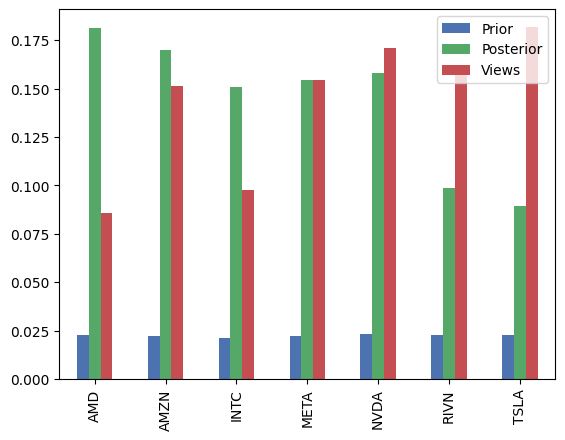

In [102]:
# visualisation of above
returns_df.plot.bar()

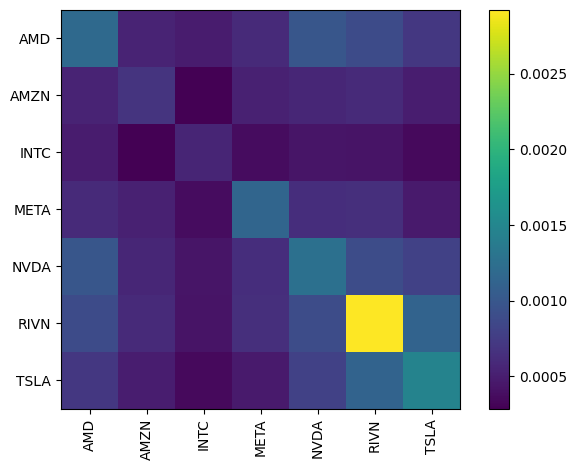

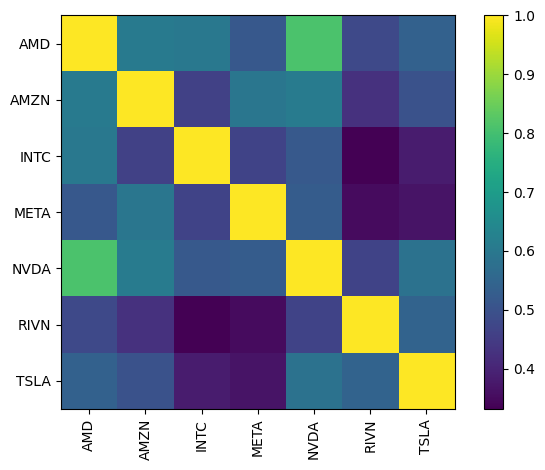

In [61]:
posterior_cov = bl.bl_cov()

covariance_plot = plotting.plot_covariance(posterior_cov, plot_correlation=False)
correlation_plot = plotting.plot_covariance(posterior_cov, plot_correlation=True)

### Efficient Frontier Weights

#### Minimum Volatility

In [103]:
ef_1 = EfficientFrontier(posterior_returns, posterior_cov)
min_vol_weights = ef_1.min_volatility()
cleaned_weights_min_vol = ef_1.clean_weights()

cleaned_weights_min_vol

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.37582),
             ('INTC', 0.57302),
             ('META', 0.01451),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.03665)])

#### Max Sharpe

In [104]:
ef_2 = EfficientFrontier(posterior_returns, posterior_cov)
max_sharpe_weights = ef_2.max_sharpe()
cleaned_weights_max_sharpe = ef_2.clean_weights()

cleaned_weights_max_sharpe

OrderedDict([('AMD', 0.00641),
             ('AMZN', 0.49558),
             ('INTC', 0.49801),
             ('META', 0.0),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.0)])

### Plot Asset Allocation Pies

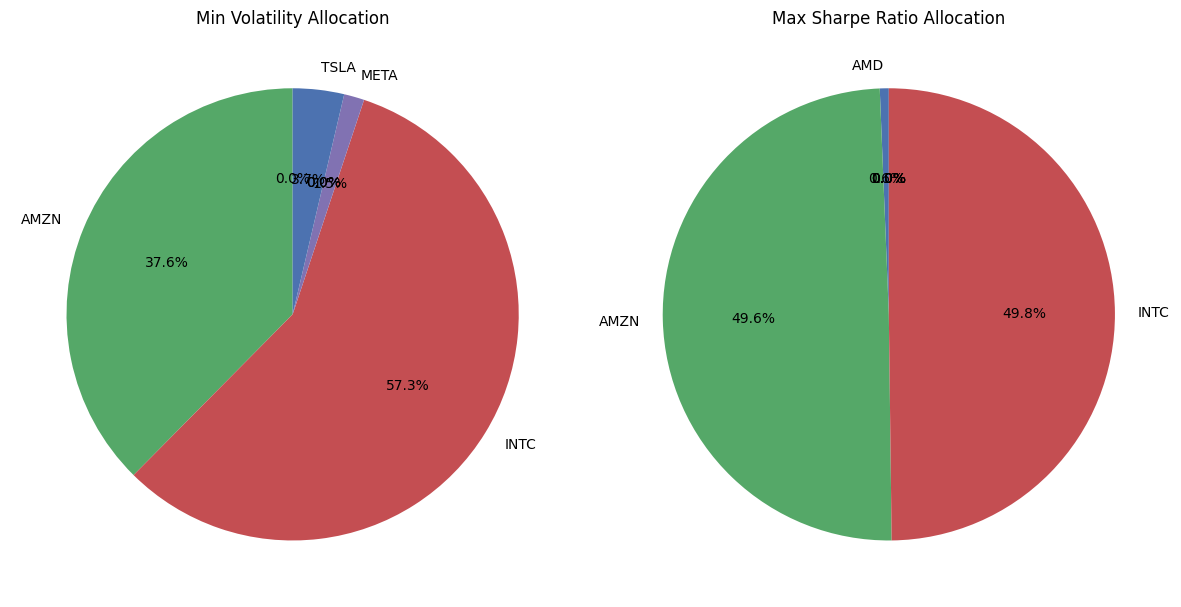

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Minimum Volaility
pd.Series(cleaned_weights_min_vol).plot.pie(
    ax=axes[0], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Min Volatility Allocation"
)

# Plot Max Sharpe
pd.Series(cleaned_weights_max_sharpe).plot.pie(
    ax=axes[1], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Max Sharpe Ratio Allocation"
)

plt.tight_layout()
plt.show()

### Portfolio Performance

#### Minimum Volatility Performance

In [106]:
ef_1.portfolio_performance(verbose=True)

Expected annual return: 15.6%
Annual volatility: 2.1%
Sharpe Ratio: 6.42


(0.15598796505965276, 0.02116882424296959, 6.4239734573268015)

#### Max Sharpe Performance

In [107]:
ef_2.portfolio_performance(verbose=True)

Expected annual return: 16.1%
Annual volatility: 2.1%
Sharpe Ratio: 6.59


(0.16066692610153344, 0.02135685377130712, 6.586500409087368)

### Get Discrete Allocation (DA)

#### Min Volatility DA

In [108]:
latest_prices = get_latest_prices(closing_prices)
da_min_vol = DiscreteAllocation(cleaned_weights_min_vol, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_min_vol.lp_portfolio(verbose=True)

#  quantities of shares that should be bought to have a 10,000£ portfolio
print(allocation)

Funds remaining: 2.16
AMD: allocated 0.000, desired 0.000
AMZN: allocated 0.380, desired 0.376
INTC: allocated 0.570, desired 0.573
META: allocated 0.000, desired 0.015
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.000, desired 0.000
TSLA: allocated 0.050, desired 0.037
Allocation has RMSE: 0.008
{'AMZN': 25, 'INTC': 115, 'TSLA': 2}


#### Max Sharpe DA

In [109]:
latest_prices = get_latest_prices(closing_prices)
da_max_sharpe = DiscreteAllocation(cleaned_weights_max_sharpe, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_max_sharpe.lp_portfolio(verbose=True)

#  quantities of shares that should be bought to have a 10,000£ portfolio
print(allocation)

Funds remaining: 3.93
AMD: allocated 0.000, desired 0.006
AMZN: allocated 0.502, desired 0.496
INTC: allocated 0.496, desired 0.498
META: allocated 0.000, desired 0.000
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.002, desired 0.000
TSLA: allocated 0.000, desired 0.000
Allocation has RMSE: 0.004
{'AMZN': 33, 'INTC': 100, 'RIVN': 1}
